In [7]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
len(words)

32033

In [10]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
block_size = 3 # context length : how many do we take to predict the next one
X,Y = [] , []

for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [12]:
#build dataset

def build_dataset(words):
    block_size = 3 # context length : how many do we take to predict the next one
    X,Y = [] , []
    
    for w in words:
    
    #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
        #print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
# ------------ now made respectable :) ---------------

In [14]:
Xtr.shape , Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [15]:
n_emb = 10 #the dimensionality of the character embedding vector
n_hidden = 200 #the number of the neurons in the hidden layer of the MLP 

g = torch.Generator().manual_seed(2147483647) # for reproductibility
C = torch.randn((vocab_size, n_emb),            generator=g)
W1 = torch.randn((n_emb* block_size, n_hidden), generator=g) * (5/3)/((n_emb* block_size)**0.5) #*0.2
#b1 = torch.randn(n_hidden,                      generator=g) *0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) *0.01
b2 = torch.randn(vocab_size,                    generator=g) *0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # numm of total parameters
for p in parameters:
    p.requires_grad = True


NameError: name 'b1' is not defined

In [26]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb] # embedd the charachters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    #linear layer
    hpreact = embcat @ W1 # b1 # hidden layer pre activation
    #BatchNorm layer
    #----------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani ) /bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #----------------------------------
    #Non-linearity 
    
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #loss funciton

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update parameters 
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break
    

      0/  200000: 3.3010
  10000/  200000: 2.1640
  20000/  200000: 2.1714
  30000/  200000: 2.2333
  40000/  200000: 2.0861
  50000/  200000: 2.0834
  60000/  200000: 1.9714
  70000/  200000: 2.1068
  80000/  200000: 2.4003
  90000/  200000: 2.2408
 100000/  200000: 2.3450
 110000/  200000: 1.9888
 120000/  200000: 1.7642
 130000/  200000: 2.0887
 140000/  200000: 2.2417
 150000/  200000: 1.8336
 160000/  200000: 2.2561
 170000/  200000: 2.0787
 180000/  200000: 2.3491
 190000/  200000: 1.9256


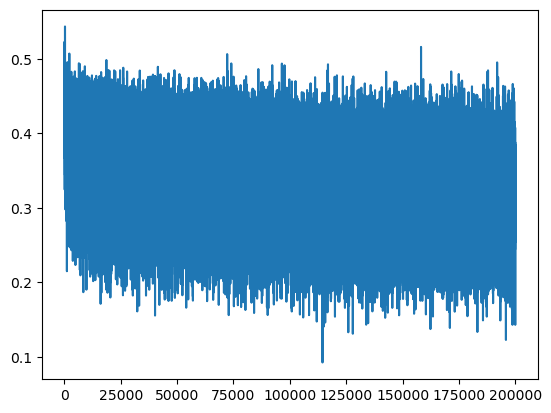

In [17]:
plt.plot(lossi)

In [27]:
#calibrate the batch norm at the end of training 

with torch.no_grad():
    #pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [34]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069214344024658
val 2.110414981842041


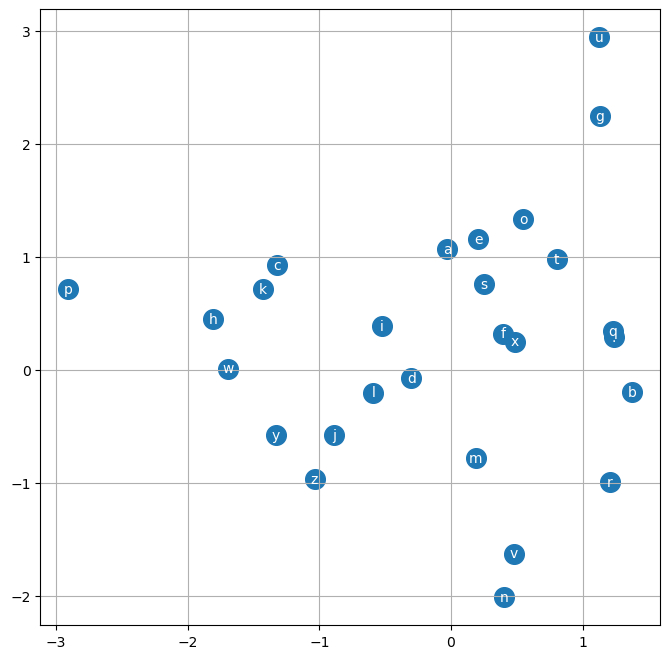

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200) 
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    out = []
    context = [0] *block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1)@ W1 +b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
med.
ryah.
reisha.
ejdrie.
cadeekaitlie.
shi.
jen.
eden.
van.
aar.
kayziah.
kalin.
shubergianaiel.
kinleenellennie.
con.
benteder.
yarue.
ehsyn.
ajahshelda.
hel.
salynn.
unizakelven.
matt.
tris.
jaiel.
praphinen.
oeseherpeica.


In [3]:
#SUMMARY --------------------------

In [87]:
#Let's train a deeper netword
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [88]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
   # break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1508
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9132
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean -0.01, std 0.66, saturated: 3.41%
layer 5 (      Tanh): mean +0.01, std 0.69, saturated: 2.25%
layer 8 (      Tanh): mean +0.01, std 0.71, saturated: 1.34%
layer 11 (      Tanh): mean -0.01, std 0.72, saturated: 1.53%
layer 14 (      Tanh): mean -0.03, std 0.74, saturated: 1.03%


Text(0.5, 1.0, 'activation distribution')

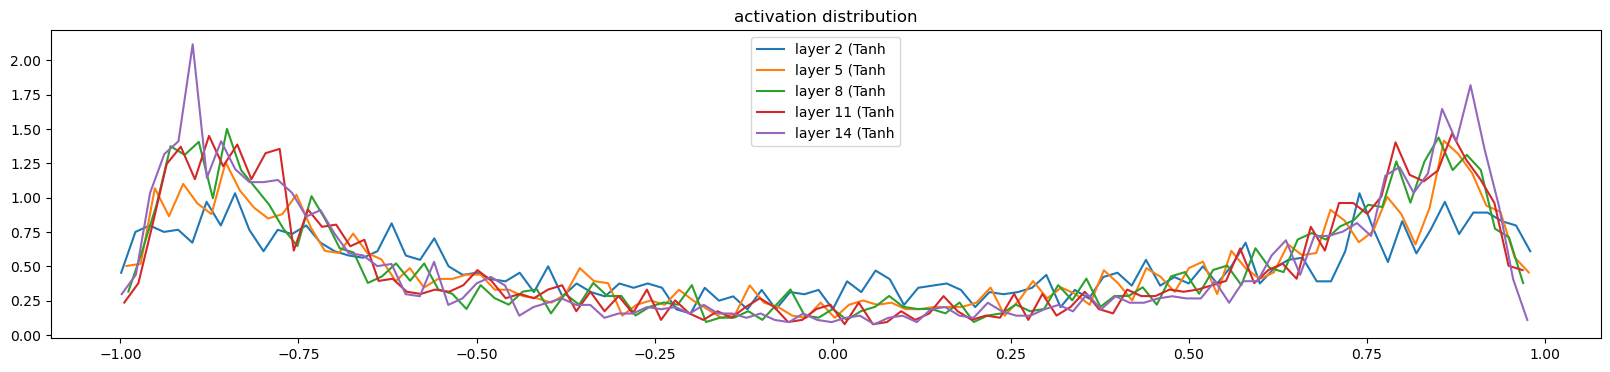

In [74]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 1.516239e-02
layer 5 (      Tanh): mean +0.000000, std 1.213361e-02
layer 8 (      Tanh): mean +0.000000, std 1.126031e-02
layer 11 (      Tanh): mean -0.000000, std 1.209653e-02
layer 14 (      Tanh): mean -0.000000, std 1.562468e-02


Text(0.5, 1.0, 'gradient distribution')

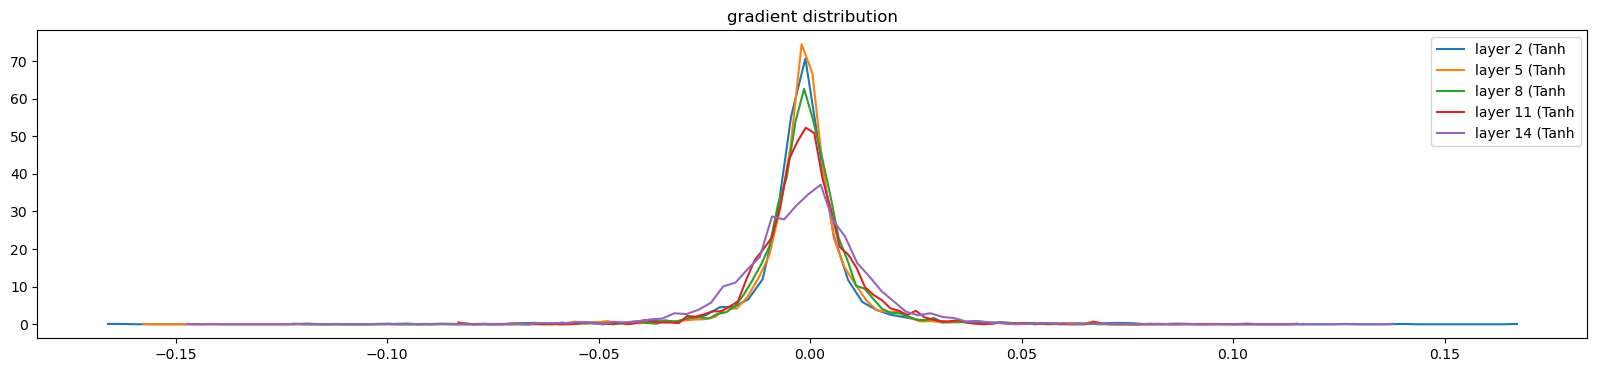

In [75]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.214379e-02 | grad:data ratio 9.043907e-02
weight  (30, 100) | mean +0.000442 | std 3.966707e-02 | grad:data ratio 1.748646e-01
weight (100, 100) | mean +0.000364 | std 1.806712e-02 | grad:data ratio 1.507597e-01
weight (100, 100) | mean -0.000058 | std 1.878922e-02 | grad:data ratio 1.629155e-01
weight (100, 100) | mean -0.000207 | std 1.885682e-02 | grad:data ratio 1.643746e-01
weight (100, 100) | mean +0.000067 | std 2.089516e-02 | grad:data ratio 1.794468e-01
weight  (100, 27) | mean +0.000445 | std 4.668703e-02 | grad:data ratio 2.804824e-01


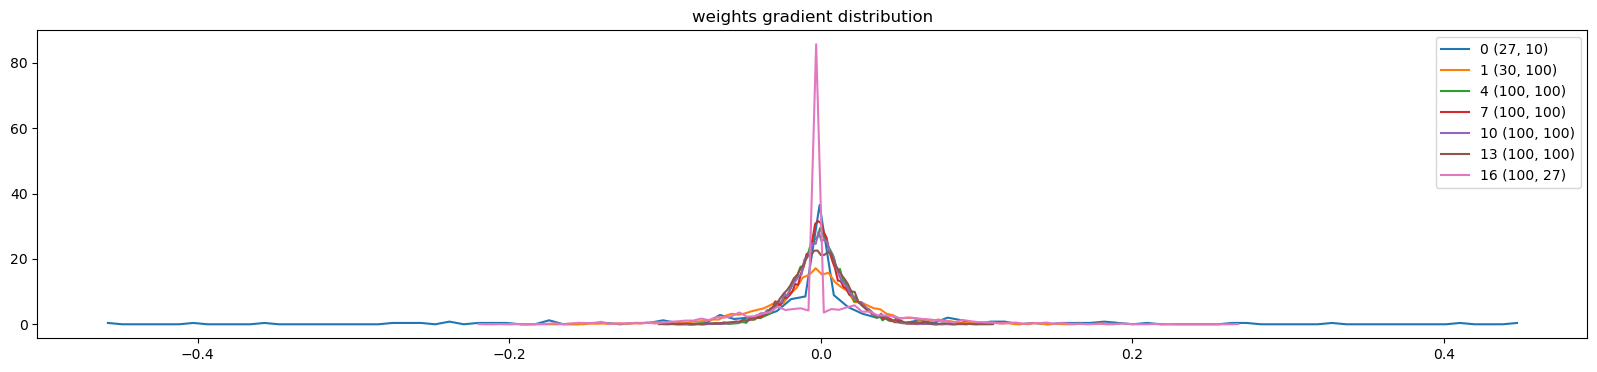

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

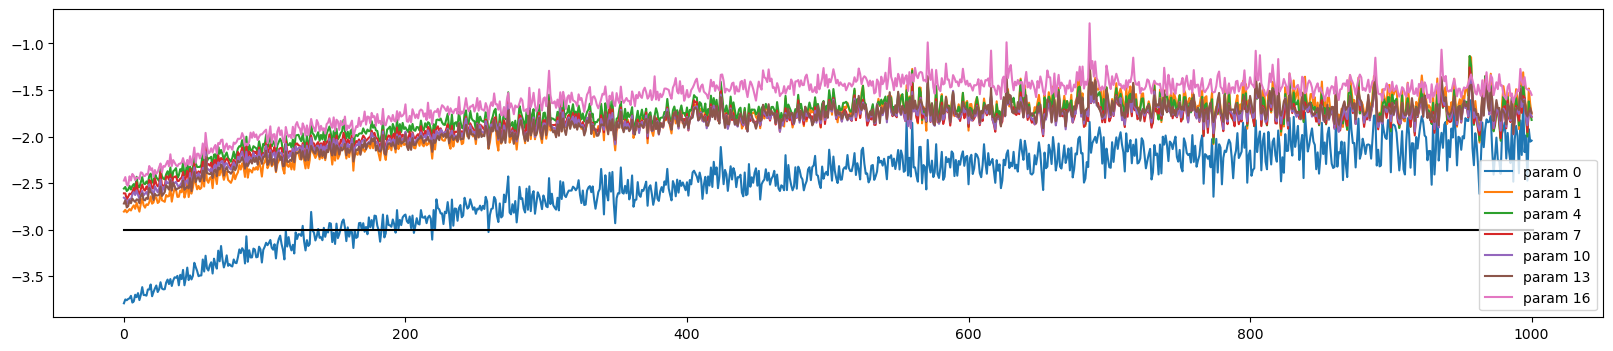

In [77]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);